# Ajustement de données issues de la méthode Volt-Ampère-métrique

Les données sont issues de la discussion `https://moodle.u-paris.fr/mod/forum/discuss.php?d=81316` à la suite du TP du mercredi 12 octobre 2022.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
I = np.array([-11.48,-9.08,-6.82,-4.47,-2.24,0,2.21,4.43,6.66,8.89,11.13])   # en mA
U = np.array([-430,-349.4,-262.7,-172.3,-86.5,0,85.2,170.7,256.5,342.7,428]) # en mV

Calcul des incertitudes

In [3]:
u_I=((1./100)*np.abs(I)+2*0.01)/(np.sqrt(3)) ; # en mA, calibre 40 mA
u_U=((0.8/100)*np.abs(U)+1)/(np.sqrt(3)) ;     # en mV, calibre 4 V

Afin d'avoir des incertitudes macroscopiques, nous les multiplions arbitrairement par 25 ici pour mieux illustrer les choses.

In [4]:
u_U=25*u_U
u_I=25*u_I

### Représentation avec `errorbar`

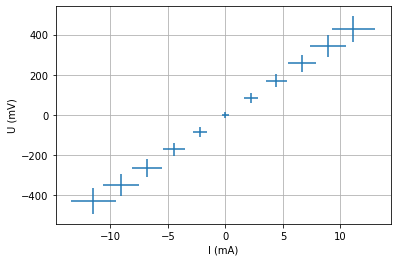

In [5]:
plt.errorbar(I,U,xerr=u_I,yerr=u_U,marker='',linestyle='')
plt.xlabel('I (mA)')
plt.ylabel('U (mV)')
plt.grid()

Attention, nous représentons ici les incertitudes `x10` pour plus de visibilité. Dans leur calcul on prendra soin de prendre la valeur absolue de $I$ et $U$ afin de ne pas avoir des incertitudes estimées négatives…

## Ajustement avec `SciPy`

R= 38.25566660938379 ± 0.1398530185611056
offset= 1.0597148444750502 ± 0.9956489361775736


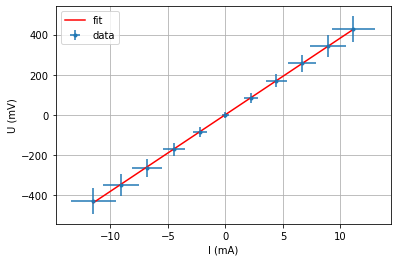

In [6]:
from scipy import stats
r  = stats.linregress(I,U)
mn = np.min(I)
mx = np.max(I)
x1 = np.linspace(mn,mx,100)
y1 = r.slope*x1+r.intercept
plt.errorbar(I, U, xerr=u_I, yerr=u_U, fmt='.', label='data')
plt.plot(x1, y1, '-r', label='fit')
plt.legend()
plt.xlabel('I (mA)')
plt.ylabel('U (mV)')
plt.grid()
print('R=', r.slope, '±', r.stderr)
print('offset=', r.intercept, '±', r.intercept_stderr)

L'ajustement est affine ici, on ne peut imposer que l'ordonnée à l'origine passe bien par 0. Le modèle ajusté n'est pas celui du modèle physique (seconde loi d'Ohm), et ce degré de liberté supplémentaire change l'estimation de $R$ malheureusement.

Par ailleurs cet ajustement ne prend pas en compte les incertitudes. La valeur de $u_R$ est assurément très sous-estimée.

## Ajustement avec `polyfit`

In [7]:
# Fitting with polyfit 
p,V = np.polyfit(I, U, 1, cov=True)   # Fit with numpy.polyfit
print(p, V)

[38.25566661  1.05971484] [[0.01955887 0.00136912]
 [0.00136912 0.9913168 ]]


In [8]:
print('R=', p[0], '±', np.sqrt(V[0][0]))

R= 38.255666609383795 ± 0.13985301856102894


Ajustement d'un polynôme de degré 1 (donc une loi toujours affine). Par ailleurs, l'estimation de l'incertitude est exact sous l'hypothèse d'indépendance de $R$ et de la pente, ce qui n'est pas exact.

Ici non plus, pas d'utilisation des incertitudes estimées sur les points de mesure.

## Ajustement avec `curvfit`
Ici nous pourrons imposer la fonction ajustée qui est une fonction linéaire, et non affine.

In [9]:
from scipy import optimize

def lin(x,a):
    return a*x

param,cov = optimize.curve_fit(lin, I, U, p0=[40], sigma=u_U)
err = np.zeros(np.size(param))

for i in range(np.size(param)):
    err[i] = np.sqrt(cov[i][i])

    print('R=', param[0], '±', err[0])

R= 38.35675800470264 ± 0.12028186068665937


Ici nous avons une estimation prenant en compte les incertitudes $u_U$, mais pas $u_I$, les plus grandes dans notre cas. L'estimation de $u_R$ est assurément trop petite.

## Estimation de l'incertitude par MC
L'outil précédent effectue le même type de calcul. Nous allons ici effectuer l'estimation de l'incertitude par MC sur la base de `curv_fit` car cet outil permet d'imposer une loi linéaire.

In [10]:
from scipy import optimize

def lin(x,a):
    return a*x

nbPseudoExp = 2048
pList = []
for i in range(nbPseudoExp):
    U_tmp = np.random.normal(U, u_U)
    I_tmp = np.random.normal(I, u_I)
    p,cov = optimize.curve_fit(lin, I_tmp, U_tmp, p0=[40])
    pList.append(p[0])

In [11]:
print('R=', np.mean(pList), '±', np.std(pList))

R= 37.40306049198292 ± 3.5809072800806767


Il nous prenons en compte non seulement l'incertitude $u_U$ mais aussi $u_I$. Et comme nous imposons un modèle linéaire conforme au modèle physique de référence, cet estimation est la plus correcte.

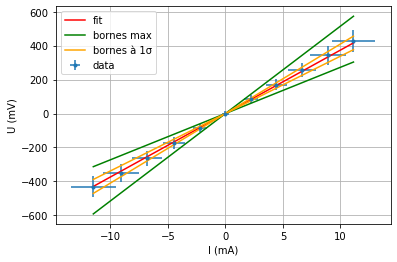

In [12]:
sMin  = np.min(pList) # min slope
sMax  = np.max(pList) # max slope 
sMean = np.mean(pList) # mean slope

mn = np.min(I)
mx = np.max(I)
x1 = np.linspace(mn,mx,2)
ymin  = sMin*x1
ymax  = sMax*x1
ymean = sMean*x1
ylow  = (sMean-np.std(pList))*x1
yhigh = (sMean+np.std(pList))*x1

plt.errorbar(I, U, xerr=u_I, yerr=u_U, fmt='.', label='data')
plt.plot(x1, ymean, 'r', label="fit")
plt.plot(x1, ymin, "g")
plt.plot(x1, ymax, "g", label="bornes max")
plt.plot(x1, ylow,  color="orange")
plt.plot(x1, yhigh, color="orange", label="bornes à 1σ")
plt.legend()
plt.xlabel('I (mA)')
plt.ylabel('U (mV)')
plt.grid()

## Ajustement avec `linfitxy`
L'outil `linfitxy` effectue ces estimations par MC automatiquement, en utilisant les incertitudes tant en abscisse qu'en ordonnées. L'outil est utilisé à l'UFR de Physique et y a été développé. Il est installé sur la machine `jupy`. Sur une autre machine, il est nécessaire d'effectuer l'installation. 

Les lignes suivantes effectuent l'installation en cas de besoin.

In [13]:
import sys
import subprocess
import importlib
fitutils_info = importlib.util.find_spec("fitutils")
if fitutils_info == None:
  subprocess.check_call(['pip', 'install', 'fitutils'])

import fitutils as fu

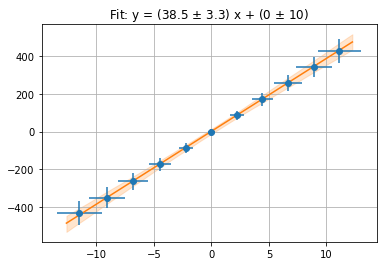

In [14]:
fu.linfitxy(I, U, u_I, u_U, plot=True)
plt.grid()

Dans notre cas, l'ajustement est affine et ne correspond malheureusement pas au modèle physique. L'utilisation est cependant très simple et méritait d'être mentionnée.

## Exploitation des données sans ajustement

Pour exploiter les données sans ajustement, nous appliquons le modèle de la seconde loi d'Ohm pour chaque point. Pour cela il faut exclure la donnée où $I=0$.

In [15]:
UU = U[I!=0]
II = I[I!=0]
u_UU = u_U[I!=0]
u_II = u_I[I!=0]

RR   = UU/II
u_RR = RR*np.sqrt( (u_UU/UU)**2 + (u_II/II)**2 )

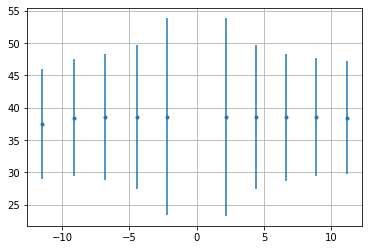

In [16]:
plt.errorbar(II, RR, yerr=u_RR, fmt='.')
plt.grid()

In [17]:
np.mean(RR)

38.42194561212065

L'estimation de l'incertitude passe aussi par un MC.

In [18]:
nbPseudoExp = 2048
rList = []

for i in range(nbPseudoExp):
    R_tmp = np.random.normal(RR, u_RR)
    rList.append(R_tmp)
print('R=', np.mean(rList), '±', np.std(rList)/np.sqrt(RR.size))

R= 38.32038263645555 ± 3.4619538218716865


On notera que l'incertitude est très similaire par l'utilisation de cette méthode à la sortie du MC de l'ajustement. Cette méthode, sans ajustement, est de fait bien plus simple à mettre en œuvre.